# Animating with hockey_rink

In this notebook, we'll look at examples of how to make animations using the hockey_rink package. The data we'll use for this is the tracking data for goals the NHL temporarily made available. We'll make an animation of the first goal we come across.

In [3]:
from hockey_rink import NHLRink
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd

plt.rc("animation", html="html5")

In [4]:
tracking_url = (
    "https://github.com/the-bucketless/nhl-data/raw/refs/heads/main/data/"
    "20232024/20232024_goals_tracking_1.parquet.gzip"
)

tracking = pd.read_parquet(tracking_url)
goal = tracking.loc[tracking.index[0]]

rink = NHLRink(ice={"visible": True})

Let's see what teams were playing in this game.

In [5]:
goal.teamAbbrev.unique()

array(['NSH', '', 'TBL'], dtype=object)

The empty string is for the puck. Let's set some appropriate colors for the matchup.

In [6]:
facecolors = {
    "NSH": "#FFB81C",
    "TBL": "#FFFFFF",
    "": "#000000",
}

edgecolors = {
    "NSH": "#041E42",
    "TBL": "#002868",
    "": "#000000",
}

scatter_sizes = {
    "NSH": 250,
    "TBL": 250,
    "": 30,
}

We'll test things out by first plotting a single frame.

In [7]:
frame = goal.loc[goal.timeStamp == goal.timeStamp.min()]

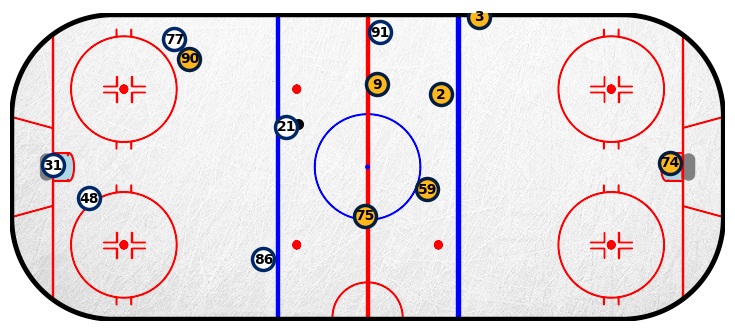

In [8]:
def draw_frame(frame, ax):
    for team, team_df in frame.groupby("teamAbbrev"):
        rink.scatter(
            x="rink_x", y="rink_y",
            data=team_df,
            facecolor=facecolors[team], edgecolor=edgecolors[team],
            s=scatter_sizes[team],
            linewidth=2.5,
            clip_to_boards=False,
            zorder=101,
            ax=ax,
        )

        if team != "":
            rink.text(
                x="rink_x", y="rink_y",
                s="sweaterNumber",
                data=team_df,
                color="black",
                fontweight="bold",
                ha="center", va="center",
                ax=ax,
            )


fig, ax = plt.subplots(figsize=(10, 4))
draw_frame(frame, ax)

Looking good. With animations, we're going to need to remove everything we drew in the previous frame before drawing a new one. Re-drawing the rink each time can be pretty slow, so we'd rather only remove the previous scatter plot and text instead of everything we're drawing. Fortunately the rink package comes with a `clear` method for exactly this.

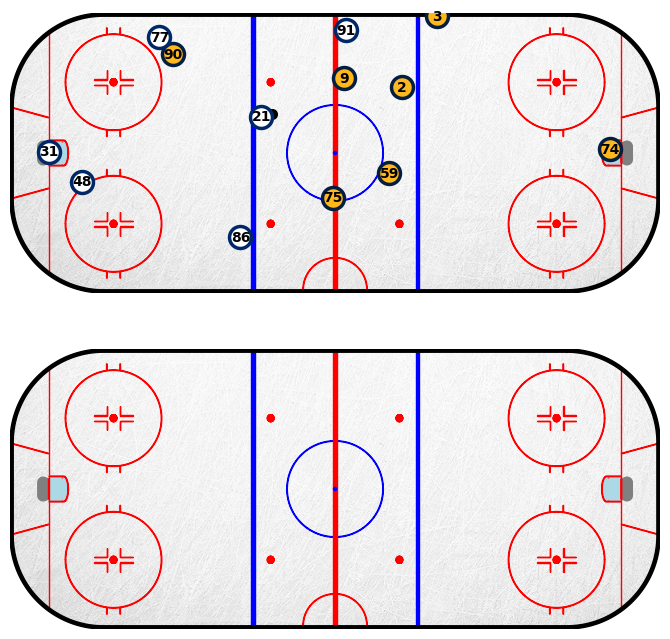

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
draw_frame(frame, axs[0])
draw_frame(frame, axs[1])
rink.clear(axs[1])

If we want to keep something around between frames, `clear` also has a parameter (`keep`) to tell it what not to clear.

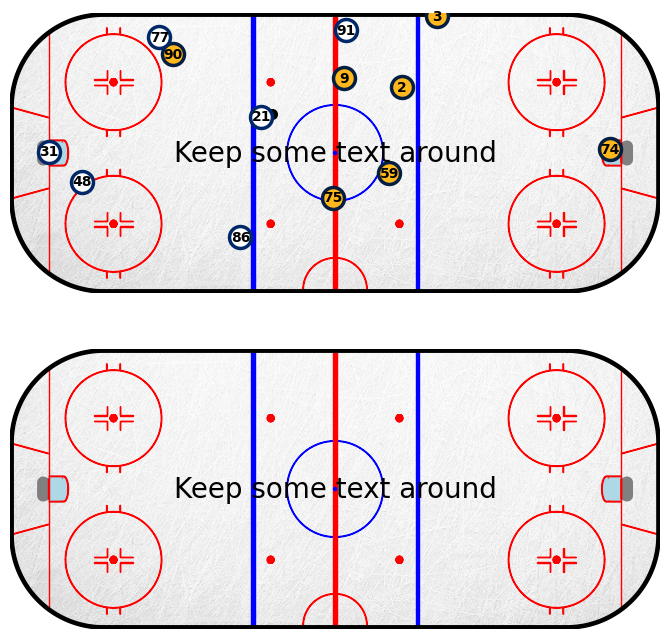

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for ax in axs:
    draw_frame(frame, ax)

    txt = rink.text(
        0, 0,
        "Keep some text around",
        ha="center", va="center", fontsize=20,
        ax=ax,
    )

rink.clear(axs[1], txt)

With that, we should be ready to animate. We'll use the timestamps in the tracking data to find each frame. Timestamps come 1/10th of a second apart so we'll have 10 frames per second.

In [11]:
timestamps = sorted(goal.timeStamp.unique())

In [12]:
def animate_frame(timestamp):
    rink.clear(ax=ax)
    frame = goal.query("timeStamp == @timestamp")
    draw_frame(frame, ax)

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
fps = 10
anim = animation.FuncAnimation(
    fig,
    animate_frame,
    frames=timestamps,
    interval=1000 / fps,
)
plt.close()

In [14]:
anim